# ЛР1, исследования с алгоритмом кнн

**Датасеты**:
- **Классификация**: Phishing Websites (OpenML ID 4534) - бинарное определение фишингового сайта (да или нет)
- **Регрессия**: Combined Cycle Power Plant (CCPP) - прогноз часовой выработки электростанции




In [56]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler, Normalizer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')


Определение метрик для регрессии

In [57]:
def regression_metrics_map(y_true, y_pred):
    return {
        'RMSE': float(root_mean_squared_error(y_true, y_pred)),
        'MAE': float(mean_absolute_error(y_true, y_pred)),
        'R2' : float(r2_score(y_true, y_pred))
    }

def plot_confusion(cm, title, labels=None):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Purples'); plt.title(title); plt.show()


 Загрузка датасетов и предобработка значений перед обучением

In [58]:
# Phishing Websites (OpenML id=4534)
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

ds = fetch_openml(data_id=4534, as_frame=True)
df = ds.frame.copy()

# Изначально значеняи должны быть -1 и 1
print("Raw target unique:", df["Result"].astype(int).unique())

# Маппим в {0,1}: (фишинговый сайт) -> 1,(легитимный) -> 0
y = (df["Result"].astype(int) == 1).astype(int).to_numpy()

# Признаки: '?' маппим в NaN и далее в числа
X = df.drop(columns=["Result"]).replace("?", np.nan).apply(pd.to_numeric, errors="coerce")

from sklearn.model_selection import train_test_split

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(Xc_train.shape, Xc_test.shape)

print("y total :", np.unique(y, return_counts=True))
print("y_train:", np.unique(yc_train, return_counts=True))
print("y_test :", np.unique(yc_test, return_counts=True))

Raw target unique: [-1  1]
(8844, 30) (2211, 30)
y total : (array([0, 1]), array([4898, 6157], dtype=int64))
y_train: (array([0, 1]), array([3918, 4926], dtype=int64))
y_test : (array([0, 1]), array([ 980, 1231], dtype=int64))


Так же загружаем датасет с электростанциями

In [59]:
import os

path = 'Folds5x2_pp.xlsx'
if not os.path.exists(path):
    raise FileNotFoundError("Нужно добавить 'Folds5x2_pp.xlsx' к файлу исполнения")

#  Combined Cycle Power Plant (CCPP)
df_reg = pd.read_excel(path)
y_reg = df_reg['PE'].to_numpy()
X_reg = df_reg.drop(columns=['PE']).to_numpy()
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
Xr_train.shape, Xr_test.shape


((7654, 4), (1914, 4))

 Дефолтная классификация и оценка качества

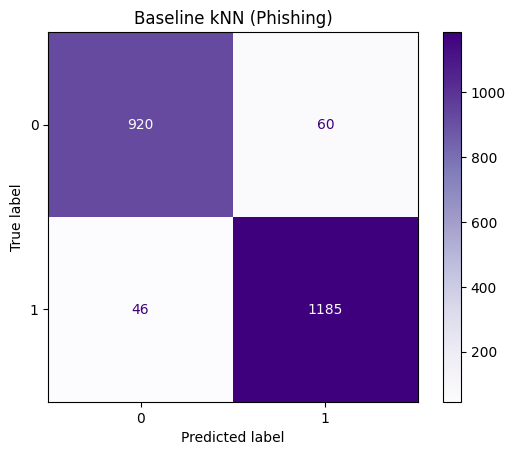

In [60]:
pipe_cls = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("knn", KNeighborsClassifier())
]).fit(Xc_train, yc_train)

yc0 = pipe_cls.predict(Xc_test)
cm0 = confusion_matrix(yc_test, yc0, labels=[0,1])
plot_confusion(cm0, "Baseline kNN (Phishing)", labels=[0,1])


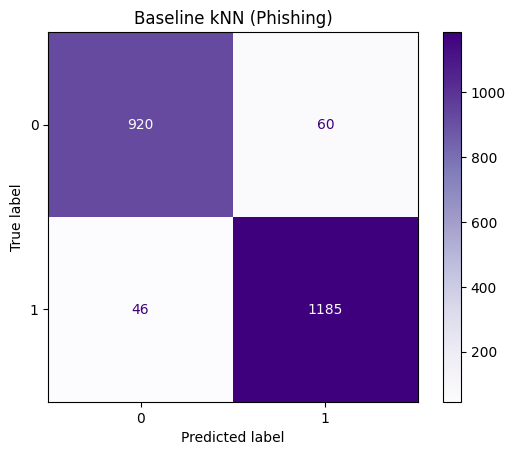

Baseline classification: {'Accuracy': 0.9520578923563998, 'MacroF1': 0.9513591526963059}
Baseline regression (Заводы): {'RMSE': 3.92214344774135, 'MAE': 2.8835506792058534, 'R2': 0.9469650542647983}


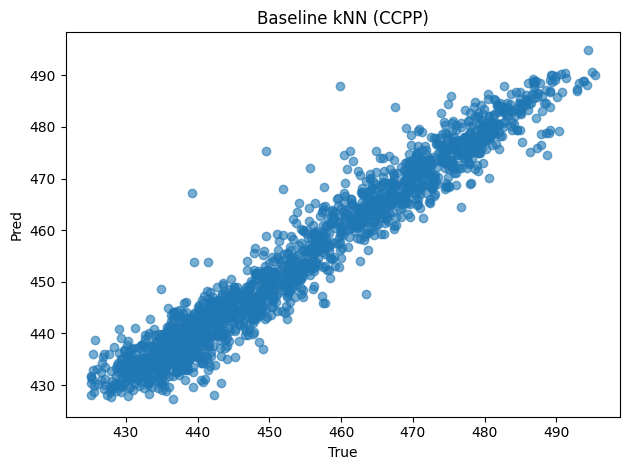

In [61]:
# Классификация дефолтная
pipe_cls = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("knn", KNeighborsClassifier())
]).fit(Xc_train, yc_train)

yc0 = pipe_cls.predict(Xc_test)
cm0 = confusion_matrix(yc_test, yc0, labels=[0, 1])
plot_confusion(cm0, "Baseline kNN (Phishing)", labels=[0, 1])
base_cls = {'Accuracy': accuracy_score(yc_test, yc0), 'MacroF1': f1_score(yc_test, yc0, average='macro')}
print('Baseline classification:', base_cls)

# Регрессия baseline
knn_r0 = KNeighborsRegressor().fit(Xr_train, yr_train)
yr0 = knn_r0.predict(Xr_test)
base_reg = regression_metrics_map(yr_test, yr0)
print('Baseline regression (Заводы):', base_reg)
plt.figure()
plt.scatter(yr_test, yr0, alpha=0.6)
plt.xlabel('True')
plt.ylabel('Pred')
plt.title('Baseline kNN (CCPP)')
plt.tight_layout()
plt.show()


 Улучшение бейзлайна (Scale/Normalize + CV‑тюнинг)

Improved classification: {'Accuracy': 0.9724106739032112, 'MacroF1': 0.9720054838706329}
Best params (cls): {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}


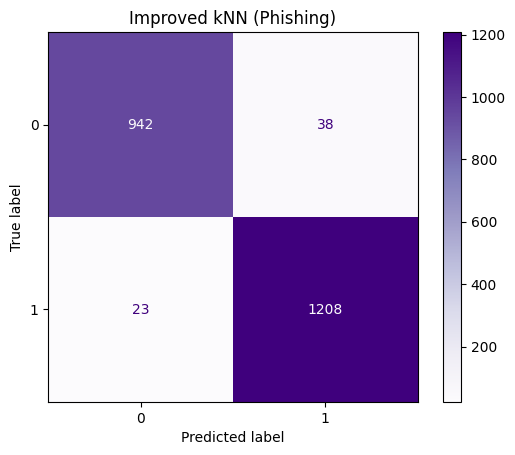

In [62]:
# Классификация на две стратегии: без нормализации и cosine+Normalizer
cv_c = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
pipe_raw = Pipeline([('knn', KNeighborsClassifier())])
grid_raw = {'knn__n_neighbors': [3, 5, 7, 9, 11], 'knn__weights': ['uniform', 'distance'],
            'knn__metric': ['euclidean', 'manhattan']}

pipe_cos = Pipeline([('norm', Normalizer()), ('knn', KNeighborsClassifier(algorithm='brute', metric='cosine'))])
grid_cos = {'knn__n_neighbors': [3, 5, 7, 9, 11], 'knn__weights': ['uniform', 'distance']}

gs_raw = GridSearchCV(pipe_raw, grid_raw, cv=cv_c, n_jobs=-1, scoring='f1_macro', refit=True)
gs_cos = GridSearchCV(pipe_cos, grid_cos, cv=cv_c, n_jobs=-1, scoring='f1_macro', refit=True)

gs_raw.fit(Xc_train, yc_train)
gs_cos.fit(Xc_train, yc_train)
best_cls = gs_cos if gs_cos.best_score_ > gs_raw.best_score_ else gs_raw
yc1 = best_cls.predict(Xc_test)
imp_cls = {'Accuracy': accuracy_score(yc_test, yc1), 'MacroF1': f1_score(yc_test, yc1, average='macro')}

print('Improved classification:', imp_cls)
print('Best params (cls):', best_cls.best_params_)
cm1 = confusion_matrix(yc_test, yc1)
plot_confusion(cm1, 'Improved kNN (Phishing)', labels=[0, 1])


In [63]:

# Регрессия со скейлингм признаков + трансформация цели и подбор оптимального k
cv_r = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
pipe_r = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])
ttr = TransformedTargetRegressor(regressor=pipe_r, transformer=PowerTransformer(method='yeo-johnson', standardize=True))
grid_r = {
    'regressor__knn__n_neighbors': [3, 5, 9, 13, 17, 21, 25, 31, 33, 37],
    'regressor__knn__weights': ['distance'],
    'regressor__knn__metric': ['minkowski'],
    'regressor__knn__p': [1, 2]
}
gs_r = GridSearchCV(ttr, grid_r, cv=cv_r, n_jobs=-1, scoring='neg_root_mean_squared_error', refit=True)
gs_r.fit(Xr_train, yr_train)
yr1 = gs_r.predict(Xr_test)
imp_reg = regression_metrics_map(yr_test, yr1)
print('Improved regression:', imp_reg)
print('Best params (reg):', gs_r.best_params_)


Improved regression: {'RMSE': 3.5023280282674283, 'MAE': 2.5162251492885845, 'R2': 0.9577108631131721}
Best params (reg): {'regressor__knn__metric': 'minkowski', 'regressor__knn__n_neighbors': 9, 'regressor__knn__p': 1, 'regressor__knn__weights': 'distance'}


#### Сравнение обычного обучения и улучшенного с подбором параметров

In [64]:
print('\nСравнение (Classification) Macro‑F1')
display(pd.DataFrame([{'Model':'Baseline', **base_cls}, {'Model':'Improved', **imp_cls}]).round(4))
print('Сравнение (Regression) RMSE')
display(pd.DataFrame([{'Model':'Baseline', **base_reg}, {'Model':'Improved', **imp_reg}]).round(4))


Сравнение (Classification) Macro‑F1


,Model,Accuracy,MacroF1
0,Baseline,0.9521,0.9514
1,Improved,0.9724,0.9720


Сравнение (Regression) RMSE


,Model,RMSE,MAE,R2
0,Baseline,3.9221,2.8836,0.9470
1,Improved,3.5023,2.5162,0.9577


#### Реализация простого knn и сравнение с полученными до этого метриками

In [65]:
from collections import Counter


class HandmadeKnnClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X = np.array(X, float)
        self.y = np.array(y);
        return self

    def _dist(self, a, b):
        if self.metric == 'manhattan': return np.abs(a - b).sum(axis=1)
        return np.sqrt(((a - b) ** 2).sum(axis=1))

    def predict(self, X):
        X = np.array(X, float);
        out = []
        for row in X:
            d = self._dist(self.X, row)
            idx = np.argpartition(d, self.n_neighbors)[:self.n_neighbors]
            out.append(Counter(self.y[idx]).most_common(1)[0][0])
        return np.array(out)


class HandmadeKnnRegressor(HandmadeKnnClassifier):
    def predict(self, X):
        X = np.array(X, float);
        out = []
        for row in X:
            d = self._dist(self.X, row)
            idx = np.argpartition(d, self.n_neighbors)[:self.n_neighbors]
            out.append(self.y[idx].mean())
        return np.array(out)


s_c = HandmadeKnnClassifier(n_neighbors=5).fit(Xc_train, yc_train)
yc_s = s_c.predict(Xc_test)
s_cls = {'Accuracy': accuracy_score(yc_test, yc_s), 'MacroF1': f1_score(yc_test, yc_s, average='macro')}
print('handmade classification:', s_cls)

s_r = HandmadeKnnRegressor(n_neighbors=25).fit(Xr_train, yr_train)
yr_s = s_r.predict(Xr_test)
s_reg = regression_metrics_map(yr_test, yr_s)
print('handmade regression:', s_reg)


handmade classification: {'Accuracy': 0.9520578923563998, 'MacroF1': 0.9513591526963059}
handmade regression: {'RMSE': 4.1230335515503675, 'MAE': 3.166170114942528, 'R2': 0.9413930770930493}


#### улучшение базовой ручной реализации

In [66]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer

imp = SimpleImputer(strategy="most_frequent").fit(Xc_train)
Xc_tr = imp.transform(Xc_train);
Xc_te = imp.transform(Xc_test)

norm = Normalizer().fit(Xc_tr)  # для cosine
Xc_tr_n = norm.transform(Xc_tr);
Xc_te_n = norm.transform(Xc_te)


# расстояния и веса
def minkowski_dist(A, b, p=2):
    return (np.abs(A - b) ** p).sum(axis=1) ** (1 / p)


class HandmadeKnnClassifierWeighted:
    def __init__(self, n_neighbors=9, p=2, use_cosine=False, eps=1e-9):
        self.k, self.p, self.use_cosine, self.eps = n_neighbors, p, use_cosine, 1e-9

    def fit(self, X, y):
        self.X, self.y = X, y; return self

    def _dist(self, row):
        if self.use_cosine:
            # cosine distance = 1 - cosine_similarity
            num = (self.X * row).sum(axis=1)
            den = np.linalg.norm(self.X, axis=1) * np.linalg.norm(row)
            return 1.0 - (num / (den + self.eps))
        return minkowski_dist(self.X, row, p=self.p)

    def predict(self, X):
        preds = []
        for r in X:
            d = self._dist(r);
            idx = np.argpartition(d, self.k)[:self.k]
            w = 1.0 / (d[idx] + self.eps)  # distance weights
            # взвешенное голосование
            s = np.bincount(self.y[idx].astype(int), weights=w, minlength=2)
            preds.append(np.argmax(s))
        return np.array(preds)


# cosine и допом нормализация
knn_s = HandmadeKnnClassifierWeighted(n_neighbors=11, use_cosine=True).fit(Xc_tr_n, yc_train)
yc_s = knn_s.predict(Xc_te_n)
print("Scratch (cosine+weights):",
      accuracy_score(yc_test, yc_s),
      f1_score(yc_test, yc_s, average="macro"))

Scratch (cosine+weights): 0.9669832654907282 0.966452910135169


## Итоговые результаты

В итоге видим, что базовая реализация тоже может быть жизнеспособной, метрики достаточно высокие, но немного уступают улучшенной версии \
где мы улучшали базовый пайплайн